<a href="https://colab.research.google.com/github/freyaldi/ML/blob/main/food_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roadmap
1. Convolution Layer
2. Max Pooling
3. 1 Hidden Layer Consist of 100 Neurons ReLu
4. Output Layer 2 Neurons, Softmax activiton function



## Import Required Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

##Download The Inception V3 Weights

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-12 02:08:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   331MB/s    in 0.3s    

2022-06-12 02:08:24 (331 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

##Pre-trained Model Function

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (256, 256, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_98[0][0]']              
 ormalization)                  )                                                      

##Pipelining the pre-trained model with our own layers architecture

In [ ]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 14, 14, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


## Final Food Classification Model

In [ ]:
def create_final_model(pre_trained_model, last_output):
  
  x = tf.keras.layers.Conv2D(128, 2, activation='relu')(last_output)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Conv2D(256, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(9, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  return model

## CallBack Function

In [ ]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= 0.99):   
          self.model.stop_training = True

## Image Data Generator

In [ ]:
def generators(TRAIN_DIR, VAL_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
  
  val_datagen = ImageDataGenerator(rescale=1./255)

  ##rotation range until fill_mode values were still placeholder

  train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=(256, 256))
  
  val_generator = val_datagen.flow_from_directory(directory=VAL_DIR,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=(256, 256))
  
  return train_generator, val_generator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_DIR='/content/drive/MyDrive/Capstone Project/DATASET/BALANCED/RATIO : 0.8/TRAINING'
VAL_DIR='/content/drive/MyDrive/Capstone Project/DATASET/BALANCED/RATIO : 0.8/VALIDATION'

# Test the generators
train_generator, val_generator = generators(TRAIN_DIR, VAL_DIR)

Found 6840 images belonging to 9 classes.
Found 1710 images belonging to 9 classes.


## Train Model

In [ ]:
model = create_final_model(pre_trained_model, last_output)
history = model.fit(train_generator, epochs=40, verbose=1, validation_data=val_generator, callbacks=[Callback()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/40
342/342 [==============================] - 237s 685ms/step - loss: 1.5160 - accuracy: 0.4642 - val_loss: 0.6048 - val_accuracy: 0.8181
Epoch 2/40
342/342 [==============================] - 230s 671ms/step - loss: 0.6582 - accuracy: 0.7738 - val_loss: 0.3437 - val_accuracy: 0.8942
Epoch 3/40
342/342 [==============================] - 229s 670ms/step - loss: 0.4767 - accuracy: 0.8431 - val_loss: 0.2765 - val_accuracy: 0.9099
Epoch 4/40
342/342 [==============================] - 227s 665ms/step - loss: 0.3999 - accuracy: 0.8735 - val_loss: 0.2634 - val_accuracy: 0.9140
Epoch 5/40
342/342 [==============================] - 229s 669ms/step - loss: 0.3587 - accuracy: 0.8882 - val_loss: 0.2348 - val_accuracy: 0.9228
Epoch 6/40
342/342 [==============================] - 229s 669ms/step - loss: 0.3375 - accuracy: 0.8965 - val_loss: 0.2589 - val_accuracy: 0.9181
Epoch 7/40
342/342 [==============================] - 228s 668ms/step - loss: 0.3036 - accuracy: 0.9022 - val_loss: 0.2225 -

## Visualization

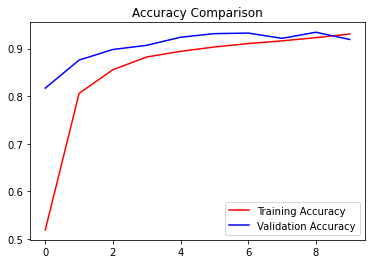

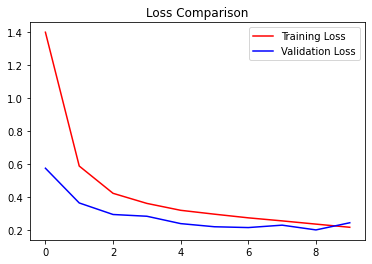

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()
plt.figure()
print('')


plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()

## Testing Code

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (256, 256))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes[0][0] == 1:
    print("AYAM_GORENG")
  elif classes[0][1] == 1:
    print("BAKSO")
  elif classes[0][2] == 1:
    print("BURGER")
  elif classes[0][3] == 1:
    print("MIE")
  elif classes[0][4] == 1:
    print("NASI_GORENG")
  elif classes[0][5] == 1:
    print("PIZZA")
  elif classes[0][6] == 1:
    print("RENDANG")
  elif classes[0][7] == 1:
    print("SALAD")
  elif classes[0][8] == 1:
    print("SATE")
  else:
    print("Image Not Valid")

  print(classes[0])

## Load the Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/C22-PS335: Capstone Project/DATASET/my_model')

loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
print(loaded_model.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(27648, 512) dtype=float32, numpy=
array([[-0.01182645,  0.00769994,  0.00041237, ...,  0.00055744,
        -0.00526027, -0.00038307],
       [ 0.006112  ,  0.01240237, -0.01094166, ...,  0.00849507,
         0.01304137, -0.01553278],
       [-0.00537173, -0.01711446,  0.00822724, ..., -0.01317008,
         0.00904069, -0.01656249],
       ...,
       [-0.01230238,  0.00797593,  0.01051713, ..., -0.02112387,
        -0.05268655,  0.01532251],
       [ 0.00404068, -0.01584794, -0.00787112, ..., -0.01193231,
         0.0592573 ,  0.00534009],
       [-0.00358953, -0.01110109,  0.00377554, ..., -0.01266326,
        -0.0293951 , -0.00363391]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
array([-6.51925802e-07, -4.02473286e-03, -3.16217449e-03, -3.16221756e-03,
       -3.16215237e-03, -6.31749351e-03,  1.29011460e-05, -8.13743100e-07,
       -3.16211488e-03,  5.31785190e-07, -2.78831692e-03, -4.86063585e-02,
       -4.

## Save The Model

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project/my_model')
model.save_weights('/content/drive/MyDrive/Capstone Project/my_weight')

tf.saved_model.save(
  model, '/content/drive/MyDrive/Capstone Project/my_model/my_model_saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project/my_model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project/my_model/my_model_saved_model/assets


## Convert Saved Model to TF-Lite

In [ ]:
# Select mode of optimization
mode = "balanced" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
export_dir = '/content/drive/MyDrive/Capstone Project/my_model'
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Capstone Project/adhaar.tflite')
tflite_model_file.write_bytes(tflite_model)